# Projet DALAS 
## CLASSIFICATION
### SOYKOK Aylin - CELIK Simay



But : Apprentissage sur la classification des items (fast or slow)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

In [27]:
df_fast = pd.read_pickle('../data/fastfashion_clean.pkl')
df_slow = pd.read_pickle('../data/slowfashion_clean.pkl')
base = pd.read_pickle('base.pkl')

In [28]:
base.head()

,Product Type,Product Name,Price,Materials,Country,Brand Type
0,Jeans,Pantalon cargo en denim,29.99,"[Cotton, Recycled cotton]",[Bangladesh],Fast Fashion
1,Jeans,Ultra High Ankle Jeggings,29.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[China],Fast Fashion
2,Jeans,Wide High Jeans,29.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[Bangladesh],Fast Fashion
5,Jeans,Wide High Cropped Jeans,25.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[Bangladesh],Fast Fashion
6,Jeans,Curvy Fit Slim High Jeans,35.99,"[Cotton, Recycled cotton, Polyester, Elastane]",[Bangladesh],Fast Fashion


In [39]:
X = base.drop(columns=['Brand Type','Product Name']) 
X = pd.get_dummies(X, columns=['Product Type'])
Y = base['Brand Type'].map({'Slow Fashion': 0, 'Fast Fashion': 1})


In [40]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

transformed_column = mlb.fit_transform(X['Materials'])
df_transformed = pd.DataFrame(transformed_column, columns=mlb.classes_)
X_reset = X.drop('Materials', axis=1).reset_index(drop=True)
df_transformed_reset = df_transformed.reset_index(drop=True)

X_transformed = pd.concat([X_reset, df_transformed_reset], axis=1)

transformed_column = mlb.fit_transform(X_transformed['Country'])

df_transformed = pd.DataFrame(transformed_column, columns=mlb.classes_)

df_transformed.columns = 'Country_' + df_transformed.columns

X_reset = X_transformed.drop('Country', axis=1).reset_index(drop=True)
df_transformed_reset = df_transformed.reset_index(drop=True)

X_transformed = pd.concat([X_reset, df_transformed_reset], axis=1)

In [41]:
X_transformed.head()

,Price,Product Type_Jeans,Product Type_Pantalons,Product Type_Tops,Acetate,Acrylic,Cashmere,Circulose®,Copolyester,Cotton,...,Country_Korea,Country_Mexico,Country_Morocco,Country_Myanmar,Country_Pakistan,Country_Peru,Country_Romania,Country_Sri Lanka,Country_Turkey,Country_Vietnam
0,29.99,True,False,False,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,29.99,True,False,False,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,29.99,True,False,False,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,25.99,True,False,False,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,35.99,True,False,False,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Basic classification methods

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size=0.4, random_state=42)

# Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, Y_train)
dec_tree_pred = dec_tree.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(Y_test, dec_tree_pred)}")

# Random Forest
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, Y_train)
rand_forest_pred = rand_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(Y_test, rand_forest_pred)}")

Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#  pipeline: first scales the data then applies LR
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

log_reg.fit(X_train, Y_train)
log_reg_pred = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(Y_test, log_reg_pred)}")

Logistic Regression Accuracy: 0.9987608426270136


In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Create a KMeans instance with 3 clusters: kmeans
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit model to samples
kmeans.fit(X_scaled)

# Determine the cluster labels of new_points: labels
labels = kmeans.predict(X_scaled)

# Print cluster labels of X
print(labels)

[0 0 0 ... 1 1 1]


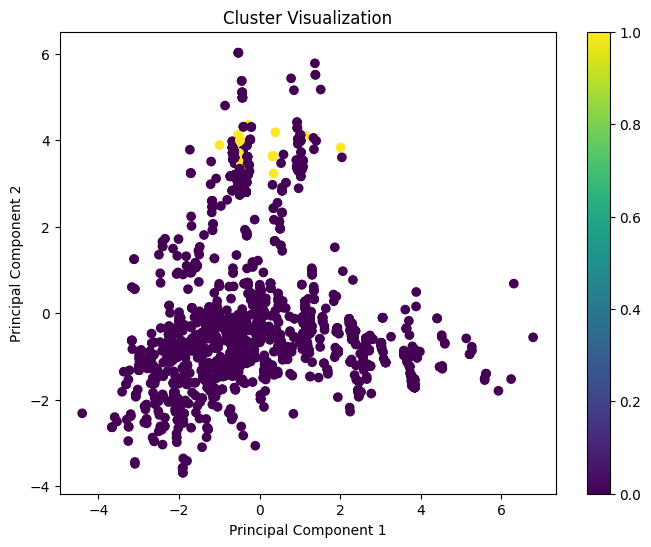

In [59]:
#using pca bcs too many dimensions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')

plt.colorbar(scatter)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.show()

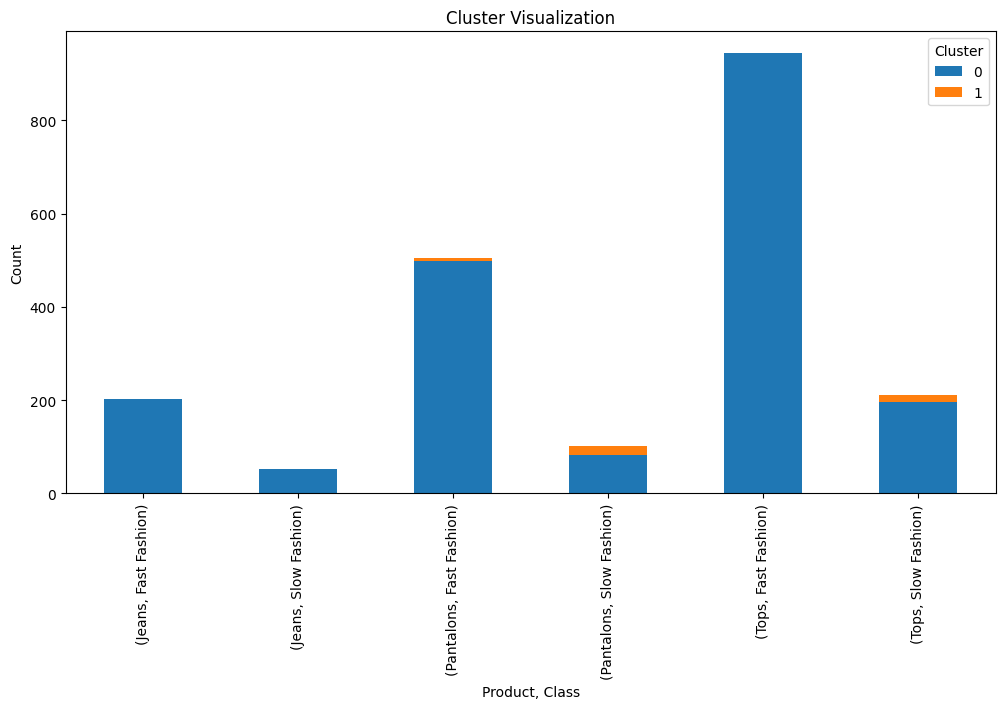

In [60]:
df_clusters = pd.DataFrame({
    'Product': base['Product Type'],
    'Class': base['Brand Type'],
    'Cluster': labels
})

df_clusters_grouped = df_clusters.groupby(['Product', 'Class', 'Cluster']).size().unstack(fill_value=0)

df_clusters_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Product, Class')
plt.ylabel('Count')
plt.title('Cluster Visualization')
plt.show()

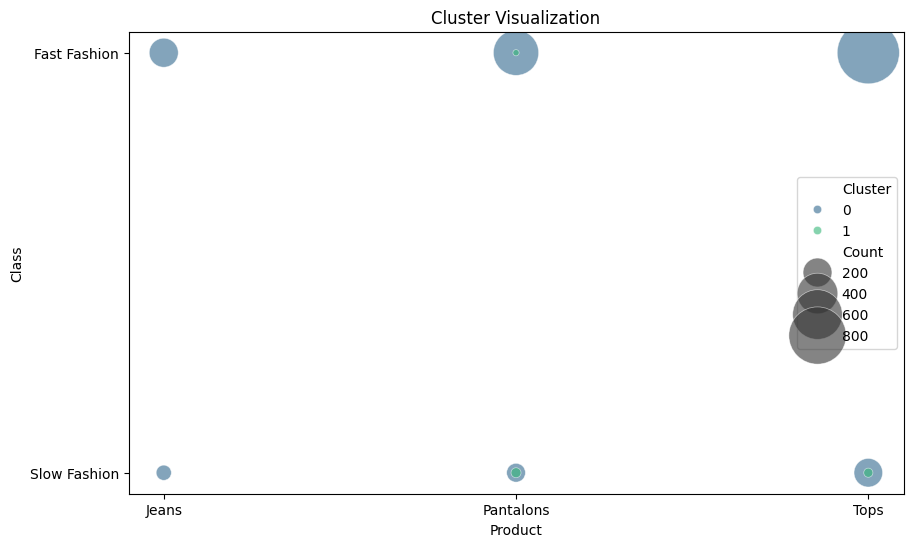

In [61]:
df_clusters = pd.DataFrame({
    'Product': base['Product Type'],
    'Class': base['Brand Type'],
    'Cluster': labels
})

# Group by 'Product' and 'Class' and count the number of instances in each cluster
df_clusters_grouped = df_clusters.groupby(['Product', 'Class', 'Cluster']).size().reset_index(name='Count')

# Create a bubble chart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clusters_grouped, x='Product', y='Class', size='Count', hue='Cluster', palette='viridis', sizes=(20, 2000), alpha=0.6)

plt.xlabel('Product')
plt.ylabel('Class')
plt.title('Cluster Visualization')
plt.show()